# Cat Mouse Data Analysis

In [1]:
%matplotlib notebook

import os
import sys

import numpy as np

import imageio
from IPython.display import HTML

import matplotlib.pyplot as plt
from matplotlib import ticker
from mpl_toolkits.mplot3d.axes3d import Axes3D
plt.ioff()

import seaborn as sns
sns.set()

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import data.analysis_tools as tools

# Data Preparation

The data is stored in $D$ in the form $D[visdepth][timestep][\alpha][\beta] = performance$

where:

$\alpha = 10 \times \mbox{learning rate} $

$\beta = 10 \times \mbox{discount rate} $

Note that $D$ is automatically averaged over runs

In [2]:
num_runs = 10
max_vis_depth = 4
num_steps = 10
n = 11

In [3]:
step_size = 10

## Loading

In [4]:
D = np.zeros((max_vis_depth + 1, num_steps + 1, n, n))

In [5]:
for run in range(1, num_runs + 1):
    for depth in range(1, max_vis_depth + 1):
        dir_input = "raw/cat_mouse/depth" + str(depth) + "/run" + str(run) + ".txt"
        with open(os.path.abspath(dir_input)) as f:
            for line in f.readlines():
                line = list(map(int, line.split()))
                a = line[0]
                b = line[1]
                for i in range(2, num_steps + 2):
                    step = i - 1
                    perf = line[i]
                    D[depth][step][a][b] += perf / num_runs

In [6]:
np.save(os.path.abspath('raw/cat_mouse/D'), D)

## Preparation of Improvement Tables

### Calculation

In [7]:
I = np.zeros((max_vis_depth + 1, num_steps + 1, n, n))

In [8]:
for depth in range(1, max_vis_depth + 1):
    for step in range(1, num_steps + 1):
        I[depth][step] = (D[depth][step] - D[depth][step - 1]) / step_size

In [9]:
i_stats = tools.get_stats(I[1:max_vis_depth + 1, 1:num_steps + 1])
i_stats

ArrayStats(min=21.569999999999983, ave=72.748915289256175, max=208.19000000000005, range=186.62000000000006)

In [10]:
np.save(os.path.abspath('raw/cat_mouse/I'), I)

### Normalization

In [11]:
I_norm = tools.normalize(I, i_stats, invert=True)

In [12]:
i_norm_stats = tools.get_stats(I_norm[1:max_vis_depth + 1, 1:num_steps + 1])
i_norm_stats

ArrayStats(min=0.0, ave=0.72575867919163961, max=1.0, range=1.0)

In [13]:
np.save(os.path.abspath('raw/cat_mouse/I_norm'), I_norm)

## Preparation of Mesh Grids

In [14]:
def_depth = 1
def_step = 10

In [15]:
'''
X_domain = np.linspace(0, 1, n)
X = np.zeros((4, n, n))
X[0] = np.full((n, n), def_depth)
X[1] = np.full((n, n), def_step * step_size)
X[2], X[3] = np.meshgrid(X_domain, X_domain)
'''
X_domain = np.linspace(0, 1, n)
X = np.zeros((2, n, n))
X[0], X[1] = np.meshgrid(X_domain, X_domain)

In [16]:
Y = I_norm[def_depth][def_step]

In [17]:
y_stats = tools.get_stats(Y)
y_stats

ArrayStats(min=0.40365448504983481, ave=0.79049219211532529, max=1.0, range=0.59634551495016519)

In [18]:
np.save(os.path.abspath('raw/cat_mouse/X'), X)
np.save(os.path.abspath('raw/cat_mouse/Y'), Y)

# Data Visualization

## Performance Distribution

In [19]:
I_flat = I_norm[1:max_vis_depth + 1, 1:num_steps + 1].flatten()

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
dist = tools.plot_dist(X=I_flat,
                       ax=ax,
                       file_name='plots/normed_perf_dist',
                       yticks=[])
plt.close()

In [21]:
dist

In [22]:
percent_in_upper_half = ((0.5 < I_flat) & (I_flat < 1.0)).sum() / I_flat.size
"{:.2%}".format(percent_in_upper_half)

'93.08%'

## Performance vs. Depth and Time Heatmap

In [23]:
'''
tools.heatmap_preprocess(X=I_norm,
                         num_steps=num_steps,
                         save_file="plots/depth_heatmap/cm/frame{:03d}.png",
                         vmin=0.5,
                         vmax=1.0,
                         )

heatmap_vid = tools.animate('plots/depth_heatmap/cm/frame',
                            'plots/depth_heatmap/cm/anim')

heatmap_vid
'''

'\ntools.heatmap_preprocess(X=I_norm,\n                         num_steps=num_steps,\n                         save_file="plots/depth_heatmap/cm/frame{:03d}.png",\n                         vmin=0.5,\n                         vmax=1.0,\n                         )\n\nheatmap_vid = tools.animate(\'plots/depth_heatmap/cm/frame\',\n                            \'plots/depth_heatmap/cm/anim\')\n\nheatmap_vid\n'

<IPython.core.display.Javascript object>


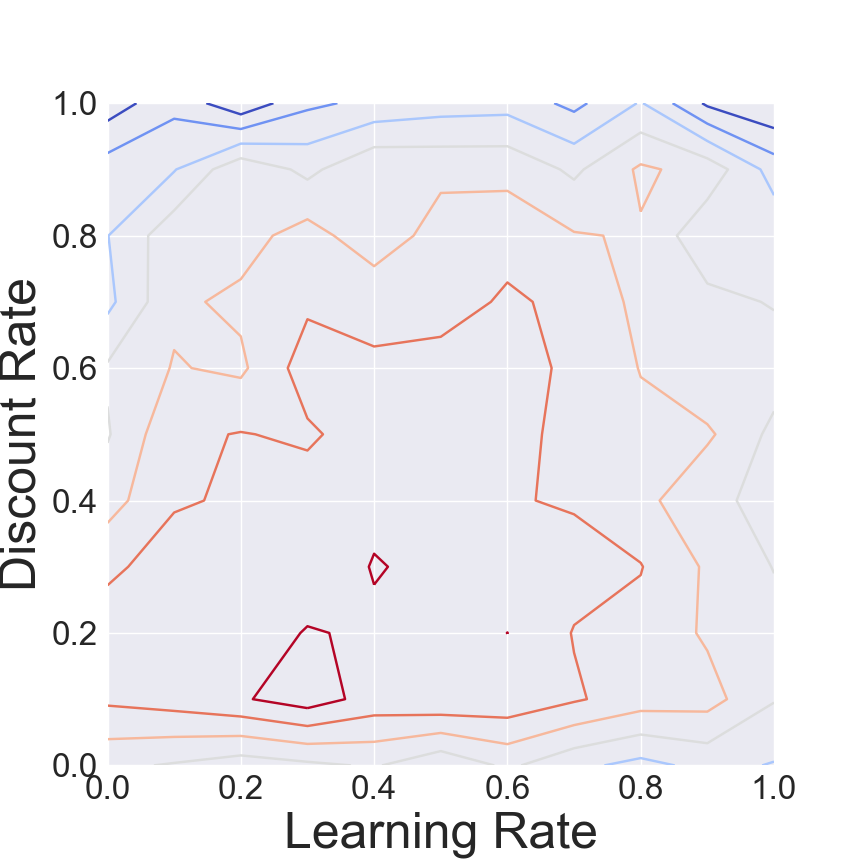

In [24]:
cmap = plt.cm.coolwarm
fig, ax = plt.subplots(figsize=(8.6, 8.6))
ax.contour(X[0], X[1], Y, cmap=cmap)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Discount Rate')
ax.xaxis.label.set_size(36)
ax.yaxis.label.set_size(36)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.savefig('plots/training_results.png', bbox_inches='tight', transparent=True)
plt.show()

## Regression

In [25]:
model = tools.PolynomialRegression(X, Y)

### Linear model

In [26]:
lin_model = model.process(degree=1)
lin_model.print_func()

0.913424*1 + -0.056874*x0 + -0.188991*x1


In [27]:
print(lin_model.r_squared)

0.235152011463


### Quadratic model

In [28]:
quad_model = model.process(degree=2)
quad_model.print_func()

0.744946*1 + 0.442895*x0 + 0.573964*x1 + -0.604418*x0^2 + 0.209299*x0*x1 + -0.867604*x1^2


In [29]:
print(quad_model.r_squared)

0.78807150507


### Cubic model

In [30]:
cube_model = model.process(degree=3)
cube_model.print_func()

0.756631*1 + 0.256942*x0 + 0.736533*x1 + -0.404777*x0^2 + 0.508903*x0*x1 + -1.366812*x1^2 + 0.002643*x0^3 + -0.407209*x0^2*x1 + 0.107606*x0*x1^2 + 0.296936*x1^3


In [31]:
print(cube_model.r_squared)

0.799414450235


## 3D Plotting

In [32]:
def plot_animate_preprocess(model, degree):
    ax = tools.plot_3d(model, degree)
    
    for ii in range(0, 360, 1):
        ax.view_init(elev=30., azim=ii)
        plt.savefig("plots/regression/degree%d/frame%d.jpeg" % (degree, ii), transparent=True)
    
    plt.close()

In [33]:
def plot_animate_beta(degree, secs=6, fps=60, vid=True):
    frame_steps = 360 // (secs * fps)
    
    images = []
    for ii in range(0, 360, frame_steps):
        images.append(imageio.imread("plots/regression/degree%d/frame%d.jpeg" % (degree,ii)))
        
    save_file = 'plots/regression/degree%d/anim%d' % (degree, fps)
    imageio.mimsave("%s.gif" % save_file, images, fps=60)
    
    tools.gif_to_mp4(save_file, fps)
    
    if vid:
        return HTML('<video controls autoplay loop> <source src="%s.mp4" type="video/mp4"> </video>' % save_file)
    else:
        return HTML('<img src="%s.gif">' % save_file)

In [34]:
ax = tools.plot_3d_normed(model, degree=1, idx=(0, 1), offsets=(-0.5, 1.5, 0.3), lims=((-0.5, 1.0), (0.0, 1.5), (0.3, 1.0)))

<IPython.core.display.Javascript object>


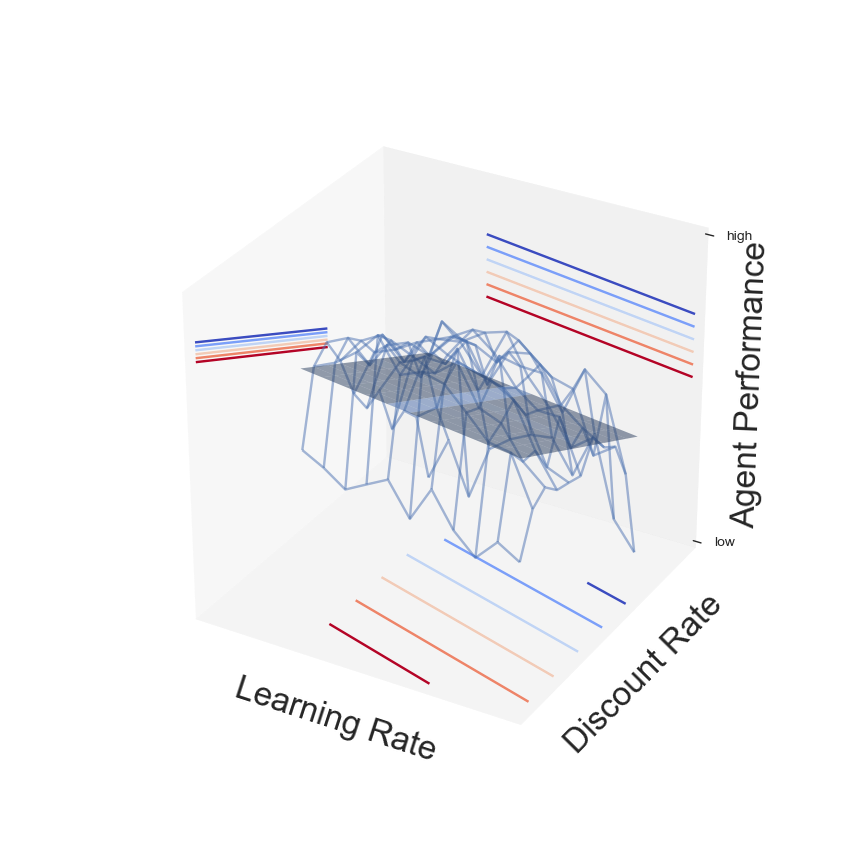

In [35]:
plt.savefig('plots/3D_results_d1.png')
plt.show()

In [36]:
ax = tools.plot_3d_normed(model, degree=2, offsets=(-0.5, 1.5, 0.3), lims=((-0.5, 1.0), (0.0, 1.5), (0.3, 1.0)))

<IPython.core.display.Javascript object>


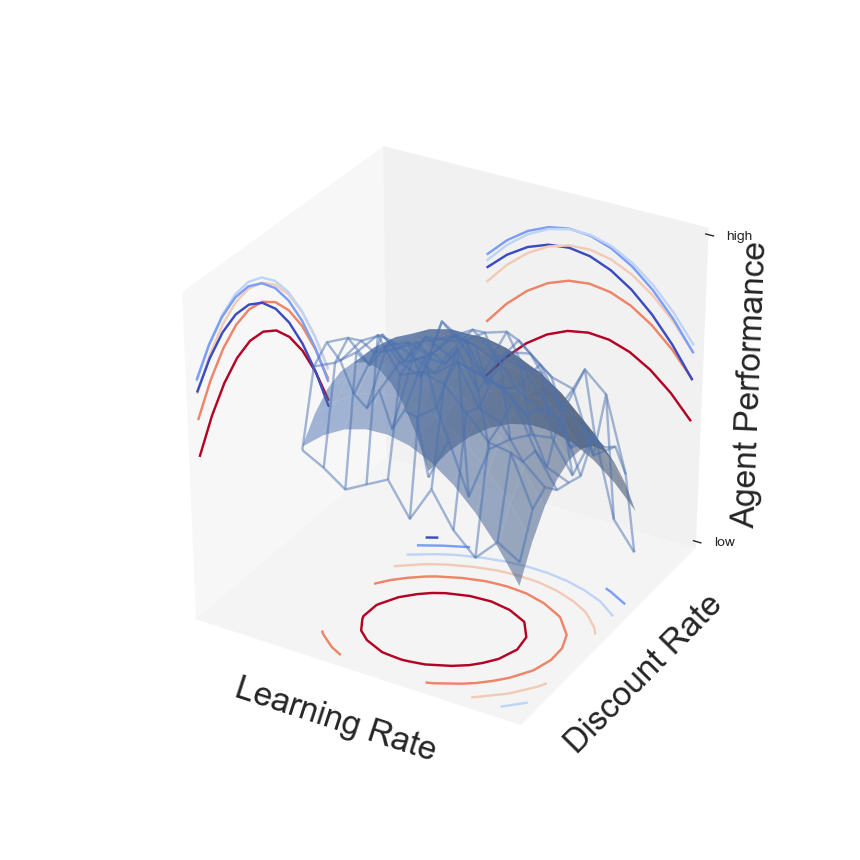

In [37]:
plt.savefig('plots/3D_results_d2.png')
plt.show()

In [38]:
ax = tools.plot_3d_normed(model, degree=3, offsets=(-0.5, 1.5, 0.3), lims=((-0.5, 1.0), (0.0, 1.5), (0.3, 1.0)))

<IPython.core.display.Javascript object>


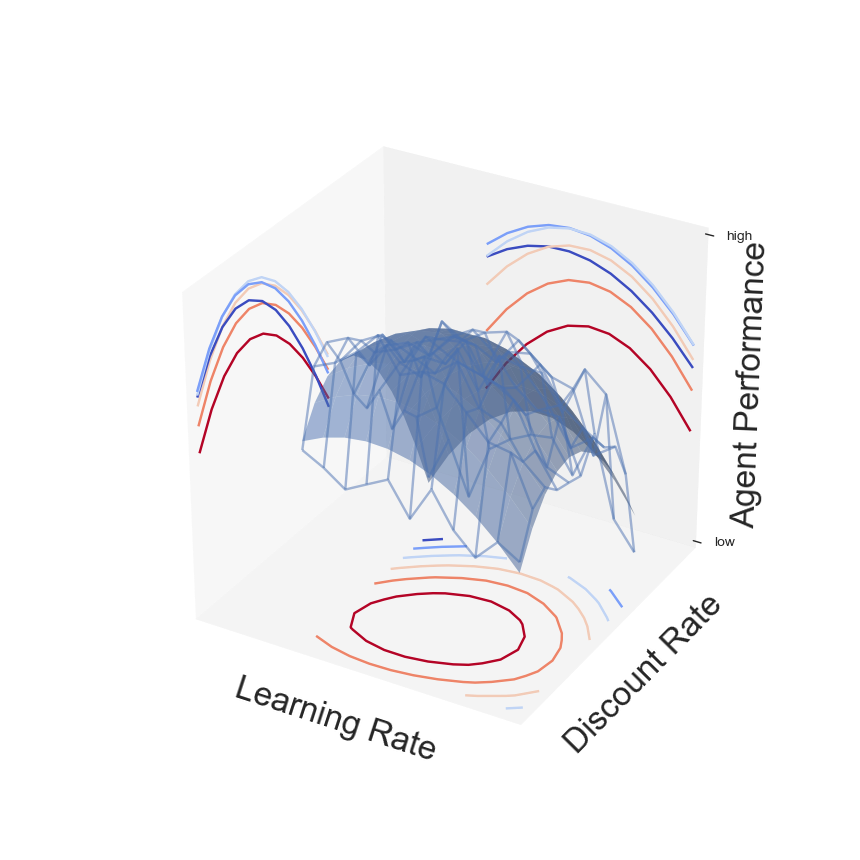

In [39]:
plt.savefig('plots/3D_results_d3.png')
plt.show()

### Linear Estimate

In [40]:
#plot_animate_preprocess(model, degree=1)

In [41]:
#anim1 = plot_animate_beta(degree=1, secs=6, fps=60)

In [42]:
#anim1

### Quadratic Estimate

In [43]:
#plot_animate_preprocess(model, degree=2)

In [44]:
#anim2 = plot_animate_beta(degree=2, secs=6, fps=60)

In [45]:
#anim2

### Cubic Estimate

In [46]:
#plot_animate_preprocess(model, degree=3)

In [47]:
#anim3 = plot_animate_beta(degree=3, secs=6, fps=60)

In [48]:
#anim3